# Intializing

In [88]:
!pip install wordcloud

  Using cached wordcloud-1.8.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)


In [2]:
!pip install numba
!pip install contractions
!pip install Unidecode
!pip install word2number

  Using cached setuptools-59.8.0-py3-none-any.whl (952 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.4.0
    Uninstalling setuptools-65.4.0:
      Successfully uninstalled setuptools-65.4.0


In [3]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

  Using cached setuptools-65.4.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.4.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.7 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import GPUtil
GPUtil.getAvailable()

[]

In [2]:
import torch
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A100 80GB PCIe MIG 3g.40gb
__CUDA Device Total Memory [GB]: 42.144366592


/DATA1/NLP/saswata_19279/nlp_279/lib/python3.10/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA A100 80GB PCIe MIG 3g.40gb with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A100 80GB PCIe MIG 3g.40gb GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [3]:
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


In [12]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Importig the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.graph_objects as go
import contractions
import unidecode
import spacy

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report 
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from numba import jit, cuda
from gensim import corpora, models, similarities, downloader
from wordcloud import WordCloud


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
train = pd.read_csv("training_data.csv")
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,10818,55770,Karachi Naya pakistan,19-03-2020,#BewareOfCOVID19. Private companies offering f...,Neutral
1,24113,69065,Toronto; Ontario; CANADA,24-03-2020,#Hoarding more than #toiletpaper it would seem...,Negative
2,6779,51731,Atlanta,18-03-2020,The only correction to a #globaleconomy global...,Negative
3,36481,81433,Fredericton; New Brunswick,07-04-2020,NB Update:. Dr. Russell begins by advising of ...,Neutral
4,22321,67273,Island Garden City of Samal,23-03-2020,Aftermath of Free Mass Testing and other Healt...,Extremely Positive


In [3]:
test = pd.read_csv("test_data.csv")
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,16188,61140,Victoria; BC; Canada,21-03-2020,Okay; so I just checked the drug prices for #P...,NaN
1,5868,50820,Durham; NC,17-03-2020,Durham's Pairwise is keenly focused on ensurin...,NaN
2,28685,73637,NaN,27-03-2020,plattsmetals: ? #PlattsCommodityNews Americas ...,NaN
3,30289,75241,A'dam NL,02-04-2020,World prices plunge as 19 virus chokes demand,NaN
4,40042,84994,Saltash; England,09-04-2020,Feeling upset ? no #eastereggs on #supermarket...,NaN


# Exploratory Data Analysis

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39664 entries, 0 to 39663
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       39664 non-null  int64 
 1   ScreenName     39664 non-null  int64 
 2   Location       31358 non-null  object
 3   TweetAt        39664 non-null  object
 4   OriginalTweet  39664 non-null  object
 5   Sentiment      39664 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


In [5]:
train.shape

(39664, 6)

#### Total number of words

In [6]:
count = 0
  
# Opens a file in read mode
f = open("training_data.csv", "r")
  
# Gets each line till end
for line in f:
    # Splits into words
    word = line.split(" ")
    # Counts each words
    count += len(word)
  
print("Total Number of Words: " + str(count))
f.close()

Total Number of Words: 1311293


### Finding the Null values

In [7]:
# Finding the null vales in the training dataset
train.isna().sum()

UserName            0
ScreenName          0
Location         8306
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
missing_values = pd.DataFrame()
missing_values['column'] = train.columns

missing_values['percent'] = [round(100* train[col].isnull().sum() / len(train), 2) for col in train.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

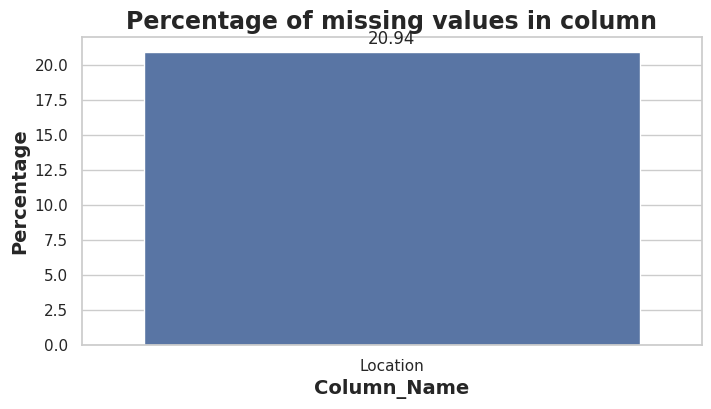

In [9]:
plt.figure(figsize=(8, 4))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

Only Location column in this dataset has 20% null entries. The column, however, is useless for our sentiment analysis. We shall therefore ignore these null values.

### Tweet origin and its Location

In [10]:
# Number of Unique locations.
loctn = list(train.Location.unique())
len(loctn)

11831

In [11]:
loc_tweet_count = pd.DataFrame(train['Location'].value_counts().sort_values(ascending=False))
loc_tweet_count.reset_index(inplace=True)
loc_tweet_count.rename(columns={'index':'Location', 'Location':'Count'}, inplace=True)
top_loc=loc_tweet_count.head(15)

[Text(0, 0, 'London'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'London; England'),
 Text(3, 0, 'New York; NY'),
 Text(4, 0, 'Washington; DC'),
 Text(5, 0, 'United Kingdom'),
 Text(6, 0, 'Los Angeles; CA'),
 Text(7, 0, 'India'),
 Text(8, 0, 'UK'),
 Text(9, 0, 'Australia'),
 Text(10, 0, 'USA'),
 Text(11, 0, 'England; United Kingdom'),
 Text(12, 0, 'Canada'),
 Text(13, 0, 'Global'),
 Text(14, 0, 'Toronto; Ontario')]

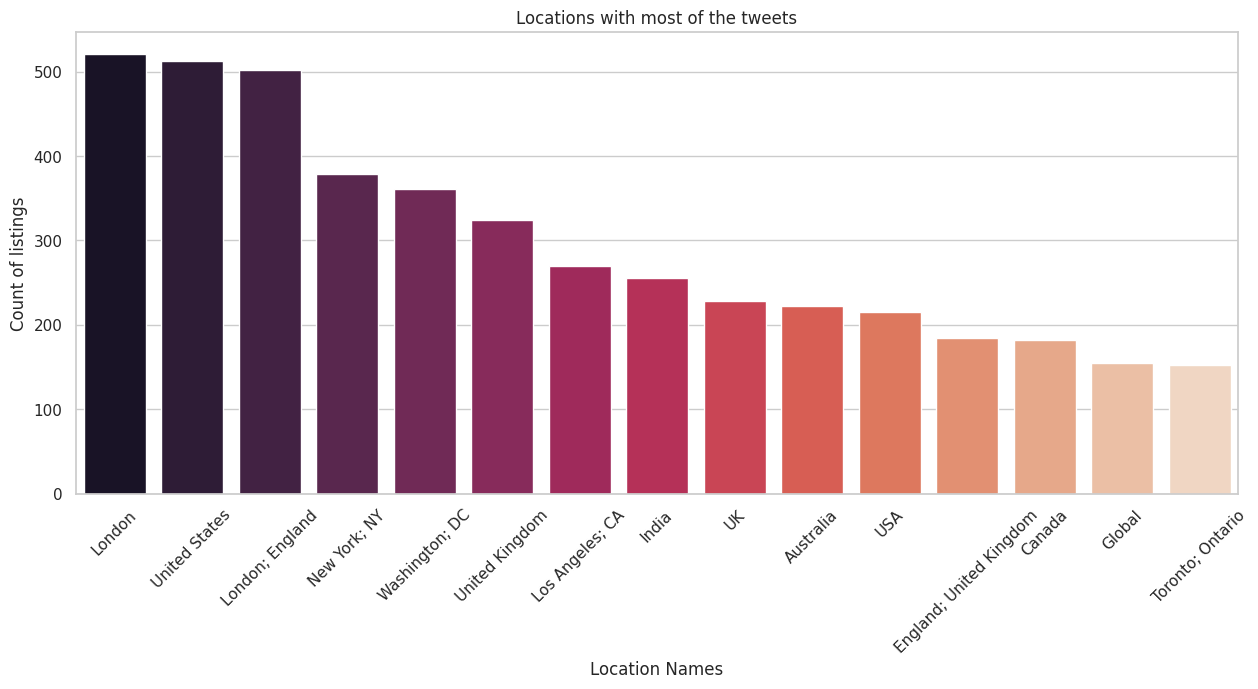

In [12]:
plt.subplots(figsize=(15,6))
top_locations=sns.barplot(x="Location", y="Count", data=top_loc,palette='rocket')
top_locations.set_title('Locations with most of the tweets')
top_locations.set_ylabel('Count of listings')
top_locations.set_xlabel('Location Names')
top_locations.set_xticklabels(top_locations.get_xticklabels(), rotation=45)

#### Findings

#### The top tweeting locations from the dataset are displayed here. London is the location that tweets the most out of the bunch. The dataset has some anomalies, such as the representation of "London", "London; England", and "England; United Kingdom" as two different places. This can be disregarded because it will not aid in the process of sentiment analysis.

In [13]:
# Converting the data type of 'TweetAt' column in the Dataframe 'POI' to datetime format.
train['TweetAt'] = pd.to_datetime(train['TweetAt'], errors='coerce')

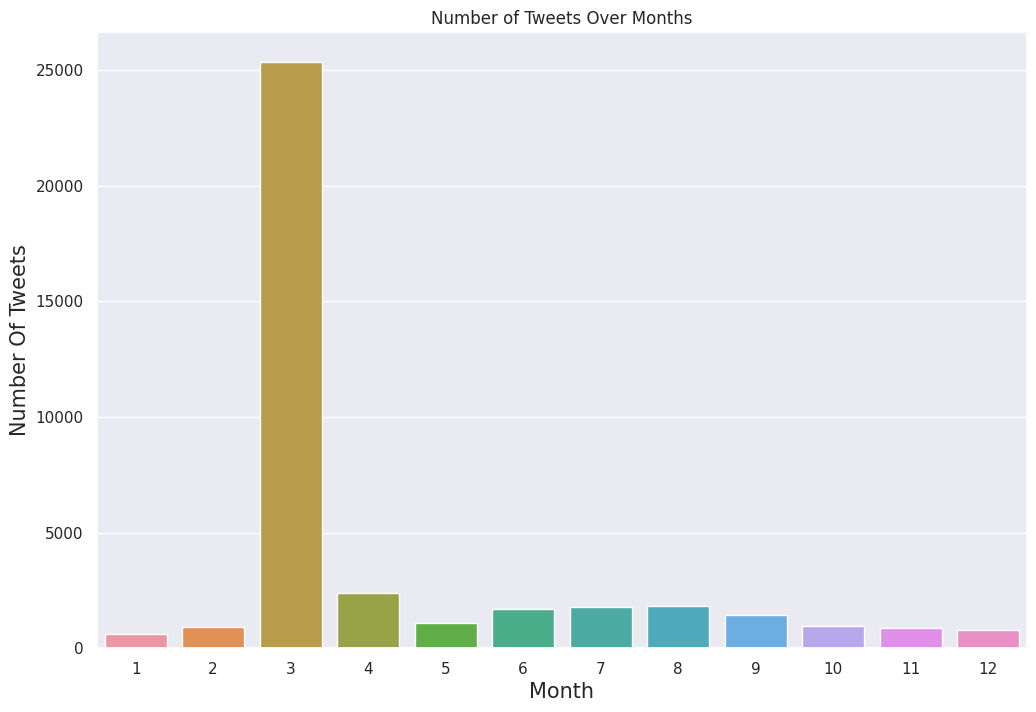

In [14]:
# Creating an Addtional column as 'Month' in Datatframe 'POI' for Month by taking the month part of 'TweetAt' column.
train['Month']=train['TweetAt'].dt.month


MonthlyCount=train.groupby('Month')['Sentiment'].count().reset_index()
MonthlyCount=MonthlyCount.rename(columns={'Sentiment':'No_Of_Tweets'})

sns.set(rc={'figure.figsize':(12,8)})
ax =sns.barplot(x="Month",y="No_Of_Tweets", data=MonthlyCount)

#Setting labels and font size
ax.set(xlabel='Month', ylabel='Number Of Tweets',title='Number of Tweets Over Months')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()

In [15]:
temp = train.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,OriginalTweet
4,Positive,11021
2,Negative,9552
3,Neutral,7426
1,Extremely Positive,6385
0,Extremely Negative,5280


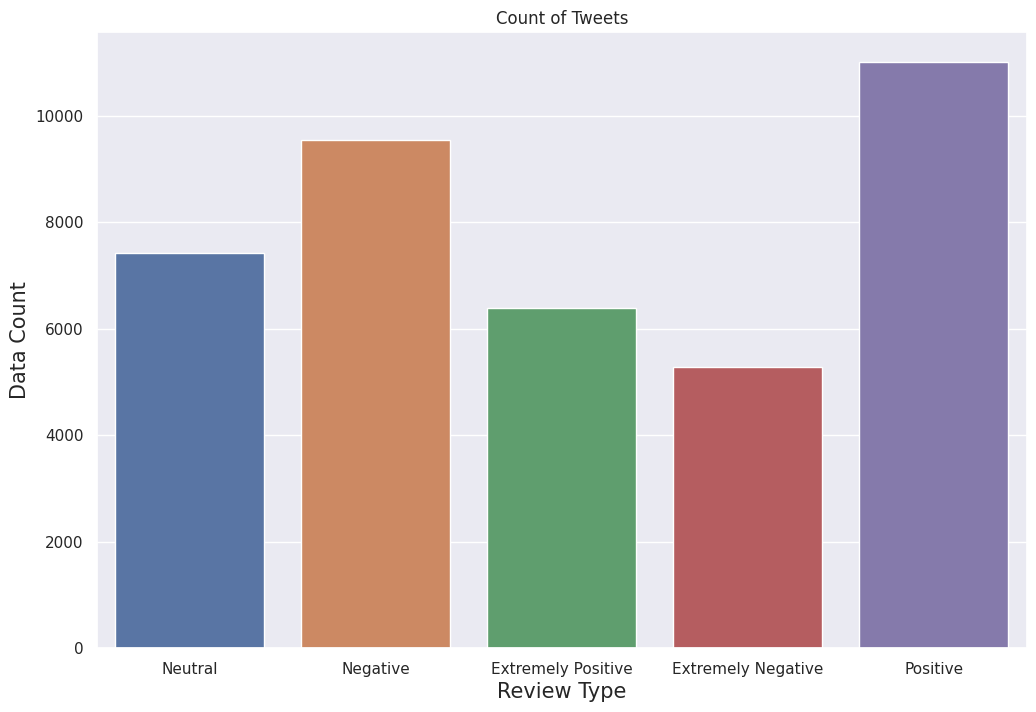

In [16]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x='Sentiment', data=train)


#Setting labels and font size
ax.set(xlabel='Review Type', ylabel='Data Count',title='Count of Tweets')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()

## Unique Values In Each Feature Coulmn

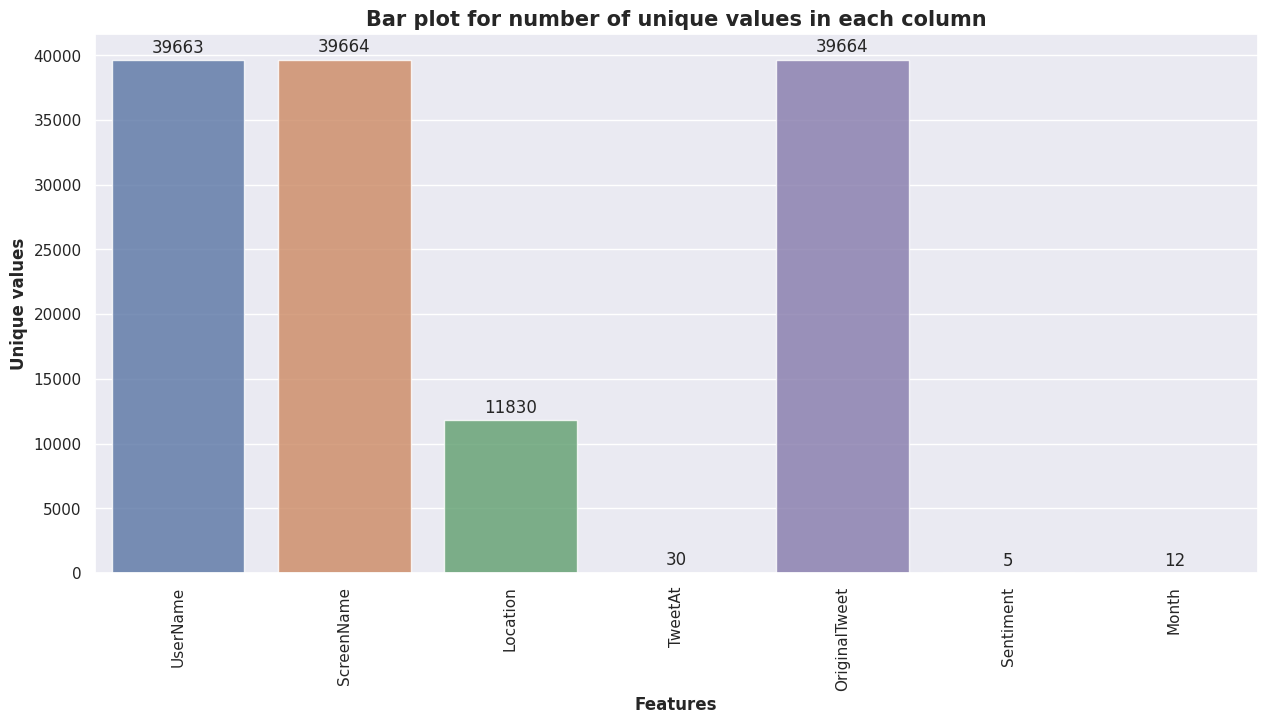

In [17]:
unique_df = pd.DataFrame()
unique_df['Features'] = train.columns
unique=[]
for i in train.columns:
    unique.append(train[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

# Data Pre-Processing

In [18]:
import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = train[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(train, 'OriginalTweet', 'clean_tweet')
data_clean.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Month,clean_tweet
0,10818,55770,Karachi Naya pakistan,2020-03-19,#BewareOfCOVID19. Private companies offering f...,Neutral,3,bewareofcovid private companies offering fast ...
1,24113,69065,Toronto; Ontario; CANADA,2020-03-24,#Hoarding more than #toiletpaper it would seem...,Negative,3,hoarding more than toiletpaper it would seem a...
2,6779,51731,Atlanta,2020-03-18,The only correction to a #globaleconomy global...,Negative,3,the only correction to a globaleconomy globale...
3,36481,81433,Fredericton; New Brunswick,2020-07-04,NB Update:. Dr. Russell begins by advising of ...,Neutral,7,nb update dr russell begins by advising of two...
4,22321,67273,Island Garden City of Samal,2020-03-23,Aftermath of Free Mass Testing and other Healt...,Extremely Positive,3,aftermath of free mass testing and other healt...


In [19]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text
    

def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def remove_newlines_tabs(text):
    """emove all the occurrences of newlines, tabs, and combinations like: \\n, \\. """
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text

def remove_whitespace(text):
    """ This function will remove extra whitespaces from the text """
    pattern = re.compile(r'\s+') 
    Without_whitespace = re.sub(pattern, ' ', text)
    # There are some instances where there is no space after '?' & ')', 
    # So I am replacing these with one space so that It will not consider two words as one token.
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text

def reducing_incorrect_character_repeatation(text):
    """This Function will reduce repeatition to two characters for alphabets and to one character for punctuations. """
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted


data_clean["clean_tweet"] = data_clean["clean_tweet"].apply(remove_accented_chars)
data_clean["clean_tweet"] = data_clean["clean_tweet"].apply(expand_contractions)
data_clean["clean_tweet"] = data_clean["clean_tweet"].apply(remove_newlines_tabs)
data_clean["clean_tweet"] = data_clean["clean_tweet"].apply(remove_whitespace)
data_clean["clean_tweet"] = data_clean["clean_tweet"].apply(reducing_incorrect_character_repeatation)
data_clean.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Month,clean_tweet
0,10818,55770,Karachi Naya pakistan,2020-03-19,#BewareOfCOVID19. Private companies offering f...,Neutral,3,bewareofcovid private companies offering fast ...
1,24113,69065,Toronto; Ontario; CANADA,2020-03-24,#Hoarding more than #toiletpaper it would seem...,Negative,3,hoarding more than toiletpaper it would seem a...
2,6779,51731,Atlanta,2020-03-18,The only correction to a #globaleconomy global...,Negative,3,the only correction to a globaleconomy globale...
3,36481,81433,Fredericton; New Brunswick,2020-07-04,NB Update:. Dr. Russell begins by advising of ...,Neutral,7,nb update dr russell begins by advising of two...
4,22321,67273,Island Garden City of Samal,2020-03-23,Aftermath of Free Mass Testing and other Healt...,Extremely Positive,3,aftermath of free mass testing and other healt...


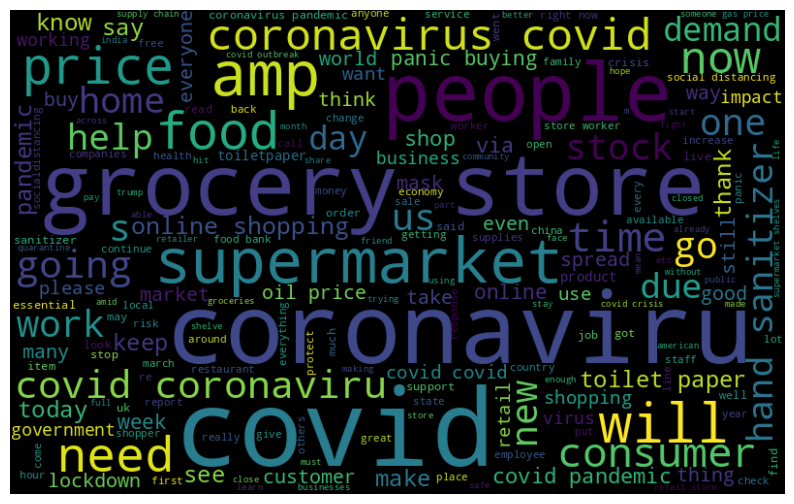

In [20]:
# create text from all cleaned tweets
all_words = ' '.join([text for text in data_clean['clean_tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

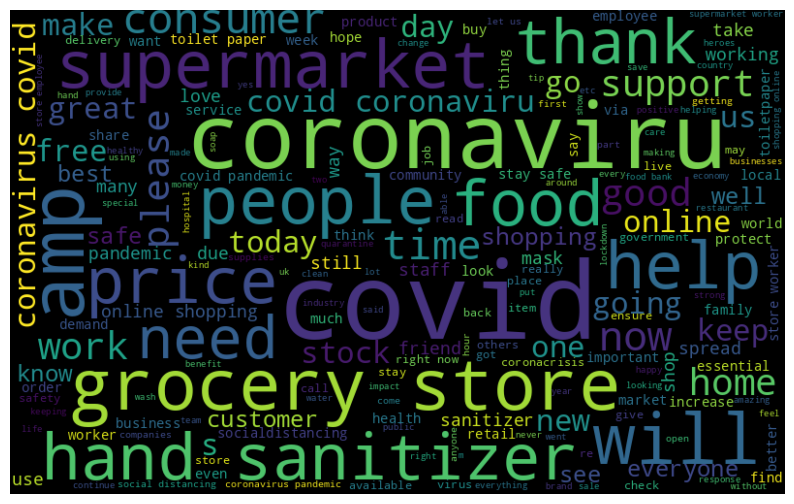

In [21]:
# create text from just normal tweets
normal_words = ' '.join([text for text in data_clean['clean_tweet'][data_clean['Sentiment'] == 'Extremely Positive']])

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

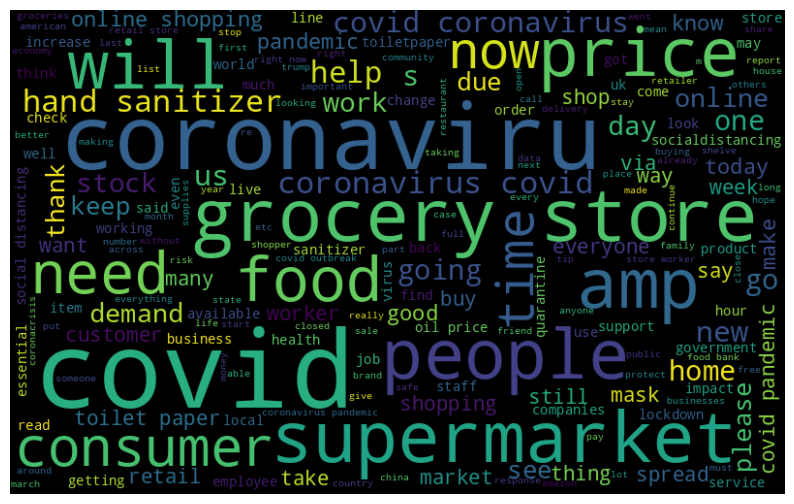

In [22]:
# create text from just normal tweets
normal_words = ' '.join([text for text in data_clean['clean_tweet'][data_clean['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

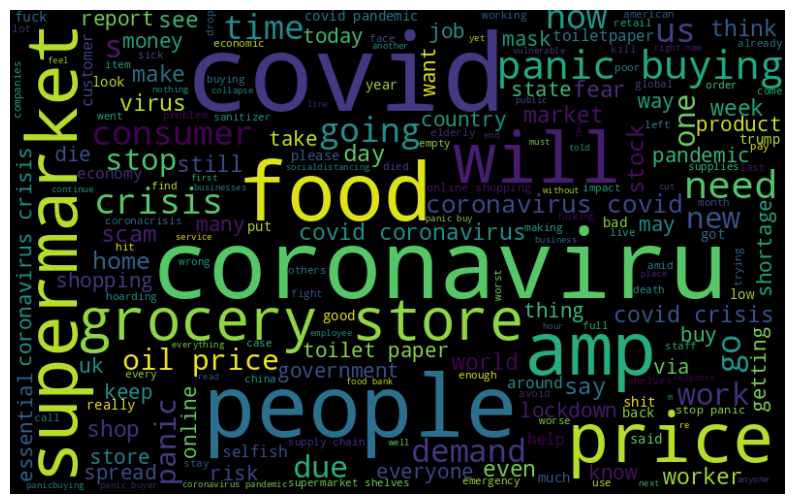

In [23]:
# create text from just normal tweets
normal_words = ' '.join([text for text in data_clean['clean_tweet'][data_clean['Sentiment'] == 'Extremely Negative']])

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

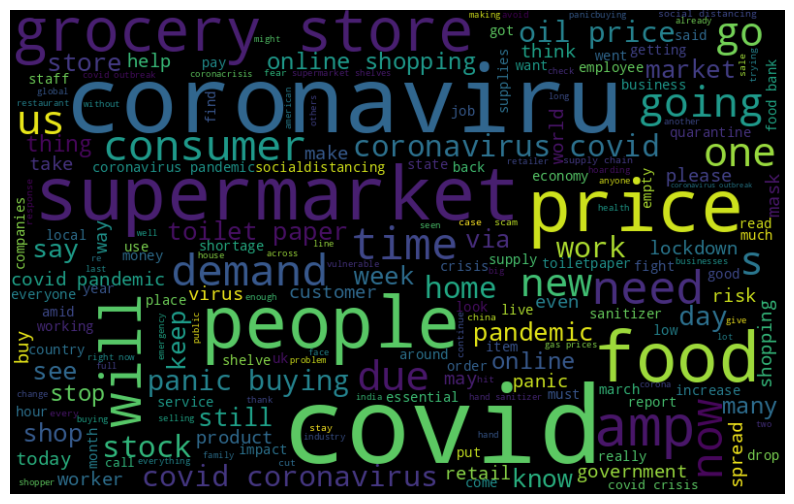

In [24]:
# create text from just normal tweets
normal_words = ' '.join([text for text in data_clean['clean_tweet'][data_clean['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

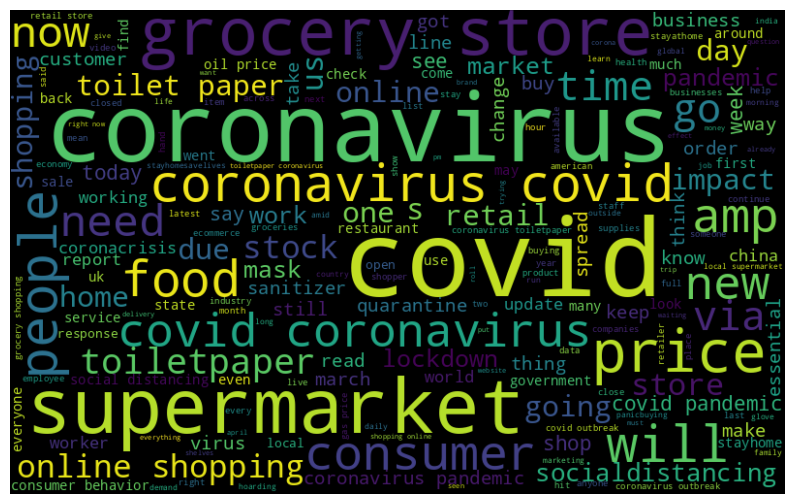

In [25]:
# create text from just normal tweets
normal_words = ' '.join([text for text in data_clean['clean_tweet'][data_clean['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
### Hashtag extraction

In [27]:
data_clean["hashtag"] = data_clean["OriginalTweet"].apply(lambda x: re.findall(r"#(\w+)", x))
data_clean.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Month,clean_tweet,hashtag
0,10818,55770,Karachi Naya pakistan,2020-03-19,#BewareOfCOVID19. Private companies offering f...,Neutral,3,bewareofcovid private companies offering fast ...,[BewareOfCOVID19]
1,24113,69065,Toronto; Ontario; CANADA,2020-03-24,#Hoarding more than #toiletpaper it would seem...,Negative,3,hoarding more than toiletpaper it would seem a...,"[Hoarding, toiletpaper, Doctors, prescriptions..."
2,6779,51731,Atlanta,2020-03-18,The only correction to a #globaleconomy global...,Negative,3,the only correction to a globaleconomy globale...,"[globaleconomy, coronavirus, AndrewYang]"
3,36481,81433,Fredericton; New Brunswick,2020-07-04,NB Update:. Dr. Russell begins by advising of ...,Neutral,7,nb update dr russell begins by advising of two...,[]
4,22321,67273,Island Garden City of Samal,2020-03-23,Aftermath of Free Mass Testing and other Healt...,Extremely Positive,3,aftermath of free mass testing and other healt...,[]


In [28]:
def tag_empty(text):
    if len(text)<1:
        text = pd.NA
    return text

data_clean["hashtag"] = data_clean["hashtag"].apply(tag_empty)
data_clean.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Month,clean_tweet,hashtag
0,10818,55770,Karachi Naya pakistan,2020-03-19,#BewareOfCOVID19. Private companies offering f...,Neutral,3,bewareofcovid private companies offering fast ...,[BewareOfCOVID19]
1,24113,69065,Toronto; Ontario; CANADA,2020-03-24,#Hoarding more than #toiletpaper it would seem...,Negative,3,hoarding more than toiletpaper it would seem a...,"[Hoarding, toiletpaper, Doctors, prescriptions..."
2,6779,51731,Atlanta,2020-03-18,The only correction to a #globaleconomy global...,Negative,3,the only correction to a globaleconomy globale...,"[globaleconomy, coronavirus, AndrewYang]"
3,36481,81433,Fredericton; New Brunswick,2020-07-04,NB Update:. Dr. Russell begins by advising of ...,Neutral,7,nb update dr russell begins by advising of two...,<NA>
4,22321,67273,Island Garden City of Samal,2020-03-23,Aftermath of Free Mass Testing and other Healt...,Extremely Positive,3,aftermath of free mass testing and other healt...,<NA>


In [29]:
import re
def hashtags(txt):
    hash = []
    for i in txt:
        hashtags = re.findall(r'#(\w+)', i)
        hash.append(hashtags)
    return hash

In [30]:
# Extremely Positive Hashtags Mining
eph = hashtags(data_clean['OriginalTweet'][data_clean['Sentiment'] == 'Extremely Positive'])
eph = sum(eph, [])

In [31]:
# Positive Hashtags Mining
ph = hashtags(data_clean['OriginalTweet'][data_clean['Sentiment'] == 'Positive'])
ph = sum(ph, [])

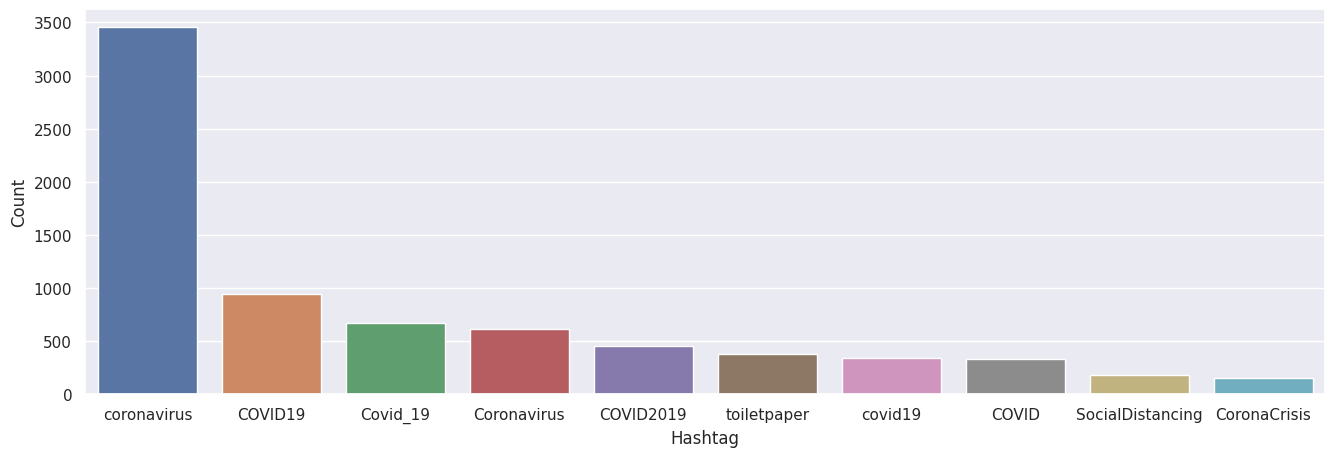

In [32]:
# making frequency distribution top 10 Extremely Positive hashtags
a = nltk.FreqDist(ph)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

In [33]:
# Neutral Hashtags Mining
nh = hashtags(data_clean['OriginalTweet'][data_clean['Sentiment'] == 'Neutral'])
nh = sum(nh, [])

In [34]:
# Negative Hashtags Mining
ngh = hashtags(data_clean['OriginalTweet'][data_clean['Sentiment'] == 'Negative'])
ngh = sum(ngh, [])

In [35]:
# Extremely Negative Hashtags Mining
engh = hashtags(data_clean['OriginalTweet'][data_clean['Sentiment'] == 'Extremely Negative'])
engh = sum(engh, [])

In [36]:
temp_df =data_clean.drop(['OriginalTweet'], axis=1, )
temp_df.groupby('Sentiment').describe(include=['O']).T

Sentiment                                          Extremely Negative  \
Location    count                                                4088   
            unique                                               2333   
            top                                       London; England   
            freq                                                   79   
clean_tweet count                                                5280   
            unique                                               5273   
            top     just as these politics have delayed the necess...   
            freq                                                    3   
hashtag     count                                                2951   
            unique                                               1954   
            top                                         [coronavirus]   
            freq                                                  426   

Sentiment                                          Extremely Positive  \
Location    count                                                5083   
            unique                                               2758   
            top                                         United States   
            freq                                                   88   
clean_tweet count                                                6385   
            unique                                               6375   
            top     many of us expect to be spending more time at ...   
            freq                                                    2   
hashtag     count                                                3636   
            unique                                               2634   
            top                                         [coronavirus]   
            freq                                                  383   

Sentiment                                                    Negative  \
Location    count                                                7470   
            unique                                               3820   
            top                                                London   
            freq                                                  130   
clean_tweet count                                                9552   
            unique                                               9525   
            top     pennsylvania grocery store takes customers tem...   
            freq                                                    3   
hashtag     count                                                5404   
            unique                                               3796   
            top                                         [coronavirus]   
            freq                                                  654   

Sentiment                 Neutral  \
Location    count            5943   
            unique           3022   
            top     United States   
            freq              112   
clean_tweet count            7426   
            unique           7375   
            top                     
            freq               16   
hashtag     count            4586   
            unique           3454   
            top     [coronavirus]   
            freq              417   

Sentiment                                                    Positive  
Location    count                                                8774  
            unique                                               4298  
            top                                                London  
            freq                                                  150  
clean_tweet count                                               11021  
            unique                                              10989  
            top     the longterm fallout of the coronavirus lockdo...  
            freq                                                    3  
hashtag     count   

### Now that we have all of the hashtags organised by the corresponding feelings, let's determine which hashtags are specific to each sentiment.

In [37]:
unq_eph = list(set(eph) - set(ph) - set(nh) - set(ngh) - set(engh))
unq_eph

['CoronaFreeWorld',
 'ElevensesWithEmmaBunting',
 'Buffalonian',
 'plauge',
 'industrytrends',
 'firstresponders',
 'DistrictCollector',
 'ThankYouPresidentTrump',
 'pottyaboutmyplanet',
 'Stayathomechallenge',
 'MyHero',
 'smallyoutubecommunity',
 'ukfood',
 'covidgas',
 'WIC',
 'workingremotely',
 'Sign',
 'ClimateAction',
 'BluBettySA',
 'WeAreAfghanistan',
 'jlmco',
 'ebayuk',
 'Suggestions',
 'ShardaUniversity',
 'autosanitizergate',
 'TodayIsTheDay',
 'course',
 'quarantaine',
 'brooklynpodcast',
 'day17',
 'indiebrand',
 'GigWorkers',
 'MaryThuoReality',
 'Superheroes',
 'masks4allchallenge',
 'keepitonthehill',
 'SHeSaidWhat',
 'ProtectOurStaff',
 'Nielsen',
 'thankyousomuch',
 'smartTech',
 'texasgirlswag',
 'whatweneed',
 'AnxietyIndex',
 'messagewrap',
 'cesarchavezday',
 'Nameandshame',
 'StonerFam',
 'pubg',
 'MHANJ',
 'littlemermaid',
 'Coronajokes',
 'Preschool',
 'JimmyHavoc',
 'Herat',
 'ManchesterCity',
 'up',
 'covid_2019',
 'pickup',
 'advisory',
 'okcorral',
 'swab

In [38]:
unq_ph =list(set(ph) - set(eph) - set(nh) - set(ngh) - set(engh))

In [39]:
unq_nh = list(set(nh) - set(eph) - set(ph) - set(ngh) - set(engh))

In [40]:
unq_ngh = list(set(ngh) - set(eph) - set(nh) - set(ph) - set(engh))

In [41]:
unique_ENGH=list(set(engh) - set(eph) - set(nh) - set(ngh) - set(ph))

# Tokenization

In [42]:
tokeniz = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = data_clean['OriginalTweet'].tolist()
Y = data_clean['Sentiment'].tolist()

for x, y in zip(X, Y):
    if y == 4:
        data.append((tokeniz.tokenize(x), 1))
    else:
        data.append((tokeniz.tokenize(x), 0))

data[:5]

[(['#BewareOfCOVID19',
   '.',
   'Private',
   'companies',
   'offering',
   'fast',
   'COVID',
   '-',
   '19',
   'tests',
   'for',
   'sale',
   '. .',
   'Consumers',
   'purchasing',
   'large',
   'amounts',
   'of',
   'products',
   'and',
   'reselling',
   'them',
   'at',
   'higher',
   'prices',
   '.',
   '2',
   '/'],
  0),
 (['#Hoarding',
   'more',
   'than',
   '#toiletpaper',
   'it',
   'would',
   'seem',
   '.',
   'At',
   'what',
   'price',
   'to',
   'society',
   '?',
   '#Doctors',
   'writing',
   'their',
   'own',
   '#prescriptions',
   'for',
   'themselves',
   'as',
   'it',
   'is',
   '-',
   'a',
   'risky',
   'thing',
   'to',
   'have',
   'allowance',
   'to',
   'do',
   '..',
   '#coronavirus',
   '. .',
   'https://t.co/Kv9t1GkTWw'],
  0),
 (['The',
   'only',
   'correction',
   'to',
   'a',
   '#globaleconomy',
   'globaleconomy',
   'thrown',
   'off',
   'by',
   '#coronavirus',
   'or',
   'any',
   'future',
   'strain',
   'of',

# Lemmatization

In [43]:
# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[('#BewareOfCOVID19', 'NN'), ('.', '.'), ('Private', 'JJ'), ('companies', 'NNS'), ('offering', 'VBG'), ('fast', 'RB'), ('COVID', 'NNP'), ('-', ':'), ('19', 'CD'), ('tests', 'NNS'), ('for', 'IN'), ('sale', 'NN'), ('. .', 'NN'), ('Consumers', 'NNP'), ('purchasing', 'VBG'), ('large', 'JJ'), ('amounts', 'NNS'), ('of', 'IN'), ('products', 'NNS'), ('and', 'CC'), ('reselling', 'VBG'), ('them', 'PRP'), ('at', 'IN'), ('higher', 'JJR'), ('prices', 'NNS'), ('.', '.'), ('2', 'CD'), ('/', 'NN')]


In [44]:
@jit(target_backend = 'cuda')
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['#BewareOfCOVID19', '.', 'Private', 'company', 'offer', 'fast', 'COVID', '-', '19', 'test', 'for', 'sale', '. .', 'Consumers', 'purchase', 'large', 'amount', 'of', 'product', 'and', 'resell', 'them', 'at', 'high', 'price', '.', '2', '/']


# Data Cleaning

In [45]:
import string
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

@jit(target_backend = 'cuda')
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

def remove_noise(tweet_tokens):
    
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in stop:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

[nltk_data] Downloading package stopwords to /home/nlp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['#bewareofcovid19', 'private', 'company', 'offer', 'fast', 'covid', 'test', 'sale', '. .', 'consumers', 'purchase', 'large', 'amount', 'product', 'resell', 'high', 'price']


In [46]:
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

final_data = []

for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))
print('The final Data is ready:')
final_data[:5]

The final Data is ready:


[({'#bewareofcovid19': True,
   'private': True,
   'company': True,
   'offer': True,
   'fast': True,
   'covid': True,
   'test': True,
   'sale': True,
   '. .': True,
   'consumers': True,
   'purchase': True,
   'large': True,
   'amount': True,
   'product': True,
   'resell': True,
   'high': True,
   'price': True},
  0),
 ({'#hoarding': True,
   '#toiletpaper': True,
   'would': True,
   'seem': True,
   'price': True,
   'society': True,
   '#doctors': True,
   'write': True,
   '#prescriptions': True,
   'risky': True,
   'thing': True,
   'allowance': True,
   '#coronavirus': True,
   '. .': True},
  0),
 ({'correction': True,
   '#globaleconomy': True,
   'globaleconomy': True,
   'throw': True,
   '#coronavirus': True,
   'future': True,
   'strain': True,
   'virus': True,
   'total': True,
   'reset': True,
   'debt': True,
   'zero': True,
   'asset': True,
   'price': True,
   '#andrewyang': True,
   'ubi': True,
   'policy': True},
  0),
 ({'update': True,
   'russe

# tf-idf Model

In [47]:
train,valid = train_test_split(data_clean,test_size = 0.2,stratify = data_clean.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (31731, 9)
valid shape :  (7933, 9)


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_tweet.values)
X_valid = vectorizer.transform(valid.clean_tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (31731, 42341)
X_valid.shape :  (7933, 42341)
y_train.shape :  (31731,)
y_valid.shape :  (7933,)


In [49]:
### Naive Bayes Classifier for MULTICLASS Classification

In [55]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.7534272478018341
Validation accuracy Score :  0.46237236858691544
              precision    recall  f1-score   support

           0       0.34      0.61      0.43       581
           1       0.39      0.56      0.46       894
           2       0.51      0.42      0.46      2340
           3       0.30      0.67      0.41       658
           4       0.63      0.40      0.49      3460

    accuracy                           0.46      7933
   macro avg       0.43      0.53      0.45      7933
weighted avg       0.52      0.46      0.47      7933



In [72]:
NB_accuracy = accuracy_score(y_valid, NB_prediction)
print('Accuracy: %f' % NB_accuracy)

NB_precision = precision_score(y_valid, NB_prediction, average="macro")
print('Precision: %f' % NB_precision)

NB_recall = recall_score(y_valid, NB_prediction, average="macro")
print('Recall: %f' % NB_recall)

NB_f1_score = f1_score(y_valid, NB_prediction, average="macro")
print('F1-macro Score: %f' % NB_f1_score)

Accuracy: 0.462372
Precision: 0.533903
Recall: 0.434256
F1-macro Score: 0.452583


In [ ]:
### Stochastic Gradient Descent-SGD Classifier( MULTICLASS CLASSIFICATION)

In [57]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2')

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.8991207336673915
Validation accuracy Score :  0.5624606075885541
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1048
           1       0.68      0.63      0.65      1362
           2       0.42      0.49      0.45      1634
           3       0.77      0.58      0.66      1977
           4       0.46      0.53      0.49      1912

    accuracy                           0.56      7933
   macro avg       0.59      0.57      0.57      7933
weighted avg       0.59      0.56      0.57      7933



In [73]:
sgd_accuracy = accuracy_score(y_valid, NB_prediction)
print('Accuracy: %f' % sgd_accuracy)

sgd_precision = precision_score(y_valid, NB_prediction, average="macro")
print('Precision: %f' % sgd_precision)

sgd_recall = recall_score(y_valid, NB_prediction, average="macro")
print('Recall: %f' % sgd_recall)

sgd_f1_score = f1_score(y_valid, NB_prediction, average="macro")
print('F1-macro Score: %f' % sgd_f1_score)

Accuracy: 0.462372
Precision: 0.533903
Recall: 0.434256
F1-macro Score: 0.452583


In [ ]:
### RANDOM FOREST CLASSIFIER (For Multiclass Classification)

In [60]:
rfc = RandomForestClassifier() 
#grid_values = {'n_estimators':[5,10], 'max_depth':[3, 5, 7]}
#classifier = GridSearchCV(classifier, param_grid = grid_values, cv=3)

# Fit the object to train dataset
rfc.fit(X_train, y_train)

rfc_preds  = rfc.predict(X_valid)
rfc_accuracy=accuracy_score(y_valid,rfc_preds)
print("Training accuracy : ",rfc.score(X_train,y_train))
print("Testing accuracy  : ",rfc_accuracy )
print(classification_report(rfc_preds,y_valid))

Training accuracy :  0.9998739403107372
Testing accuracy  :  0.5455691415605698
              precision    recall  f1-score   support

           0       0.34      0.71      0.46       512
           1       0.34      0.71      0.46       604
           2       0.51      0.51      0.51      1914
           3       0.81      0.57      0.67      2105
           4       0.62      0.48      0.54      2798

    accuracy                           0.55      7933
   macro avg       0.52      0.60      0.53      7933
weighted avg       0.60      0.55      0.56      7933



In [74]:
rfc_accuracy = accuracy_score(y_valid, rfc_preds)
print('Accuracy: %f' % rfc_accuracy)

rfc_precision = precision_score(y_valid, rfc_preds, average="macro")
print('Precision: %f' % rfc_precision)

rfc_recall = recall_score(y_valid, rfc_preds, average="macro")
print('Recall: %f' % rfc_recall)

rfc_f1_score = f1_score(y_valid, rfc_preds, average="macro")
print('F1-macro Score: %f' % rfc_f1_score)

Accuracy: 0.545569
Precision: 0.597016
Recall: 0.523392
F1-macro Score: 0.528450


In [ ]:
### Support vector machine( For Multiclass Classification)

In [62]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9104345907787337
Validation accuracy Score :  0.582125299382327
              precision    recall  f1-score   support

           0       0.41      0.71      0.52       610
           1       0.50      0.76      0.61       841
           2       0.53      0.50      0.51      2013
           3       0.72      0.62      0.67      1716
           4       0.66      0.53      0.59      2753

    accuracy                           0.58      7933
   macro avg       0.57      0.63      0.58      7933
weighted avg       0.60      0.58      0.58      7933



In [75]:
svc_accuracy = accuracy_score(y_valid, svc_prediction)
print('Accuracy: %f' % svc_accuracy)

svc_precision = precision_score(y_valid, svc_prediction, average="macro")
print('Precision: %f' % svc_precision)

svc_recall = recall_score(y_valid, svc_prediction, average="macro")
print('Recall: %f' % svc_recall)

svc_f1_score = f1_score(y_valid, svc_prediction, average="macro")
print('F1-macro Score: %f' % svc_f1_score)

Accuracy: 0.582125
Precision: 0.626826
Recall: 0.565400
F1-macro Score: 0.580426


In [ ]:
### Logistic Regression(For Multiclass Classification)

In [65]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9509627808767451
Validation accuracy Score :  0.604689272658515
              precision    recall  f1-score   support

           0       0.55      0.67      0.61       871
           1       0.62      0.69      0.65      1138
           2       0.54      0.53      0.53      1918
           3       0.74      0.64      0.68      1721
           4       0.59      0.57      0.58      2285

    accuracy                           0.60      7933
   macro avg       0.61      0.62      0.61      7933
weighted avg       0.61      0.60      0.61      7933



In [76]:
logreg_accuracy = accuracy_score(y_valid, logreg_prediction)
print('Accuracy: %f' % logreg_accuracy)

logreg_precision = precision_score(y_valid, logreg_prediction, average="macro")
print('Precision: %f' % logreg_precision)

logreg_recall = recall_score(y_valid, logreg_prediction, average="macro")
print('Recall: %f' % logreg_recall)

logreg_f1_score = f1_score(y_valid, logreg_prediction, average="macro")
print('F1-macro Score: %f' % logreg_f1_score)

Accuracy: 0.604689
Precision: 0.620924
Recall: 0.607121
F1-macro Score: 0.611678


In [ ]:
### Extreme Gradient Boosting ( For Multiclass Classification)

In [67]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.688411963064511
Validation accuracy Score :  0.5624606075885541
              precision    recall  f1-score   support

           0       0.46      0.66      0.54       743
           1       0.53      0.70      0.60       961
           2       0.45      0.53      0.49      1602
           3       0.82      0.53      0.64      2311
           4       0.56      0.53      0.54      2316

    accuracy                           0.56      7933
   macro avg       0.56      0.59      0.56      7933
weighted avg       0.60      0.56      0.57      7933



In [77]:
xgb_accuracy = accuracy_score(y_valid, xgb_prediction)
print('Accuracy: %f' % xgb_accuracy)

xgb_precision = precision_score(y_valid, xgb_prediction, average="macro")
print('Precision: %f' % xgb_precision)

xgb_recall = recall_score(y_valid, xgb_prediction, average="macro")
print('Recall: %f' % xgb_recall)

xgb_f1_score = f1_score(y_valid, xgb_prediction, average="macro")
print('F1 Score: %f' % xgb_f1_score)

Accuracy: 0.562461
Precision: 0.589905
Recall: 0.562822
F1 Score: 0.563331


In [ ]:
### CATBOOST MODEL (For Multiclass Classification)

In [69]:
clf2 = CatBoostClassifier()

clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [70]:
catboost_prediction = clf2.predict(X_valid)
catboost_accuracy = accuracy_score(y_valid,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_valid))

Training accuracy Score    :  0.6634836595127793
Validation accuracy Score :  0.6043111055086349
              precision    recall  f1-score   support

           0       0.49      0.70      0.58       742
           1       0.54      0.76      0.63       897
           2       0.51      0.55      0.53      1750
           3       0.84      0.57      0.68      2184
           4       0.62      0.58      0.60      2360

    accuracy                           0.60      7933
   macro avg       0.60      0.63      0.60      7933
weighted avg       0.63      0.60      0.61      7933



In [78]:
catboost_accuracy = accuracy_score(y_valid, catboost_prediction)
print('Accuracy: %f' % catboost_accuracy)

catboost_precision = precision_score(y_valid, catboost_prediction, average="macro")
print('Precision: %f' % catboost_precision)

catboost_recall = recall_score(y_valid, catboost_prediction, average="macro")
print('Recall: %f' % catboost_recall)

catboost_f1_score = f1_score(y_valid, catboost_prediction, average="macro")
print('F1 Score: %f' % catboost_f1_score)

Accuracy: 0.604311
Precision: 0.634651
Recall: 0.599880
F1 Score: 0.604176


In [ ]:
### All the multiclass models test accuracy in descending order

In [79]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rfc_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
1,Logistic Regression,0.604689
6,CatBoost,0.604311
0,Support Vector Machines,0.582125
5,XGBoost,0.562461
2,Random Forest,0.545569
3,Naive Bayes,0.462372
4,Stochastic Gradient Decent,0.462372


       Score       SVC    Logreg       RFC       XGB  CatBoost       SGD
0   Accuracy  0.582125  0.604689  0.545569  0.562461  0.604311  0.462372
1  Precision  0.626826  0.620924  0.597016  0.589905  0.634651  0.533903
2     Recall  0.565400  0.607121  0.523392  0.562822  0.599880  0.434256
3   F1 Score  0.580426  0.611678  0.528450  0.563331  0.604176  0.452583





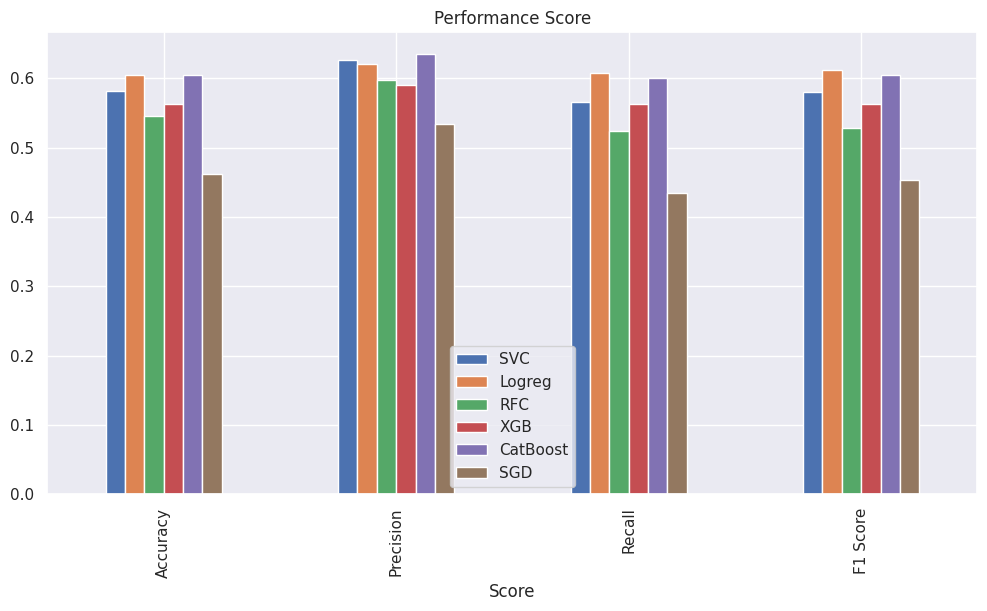

In [83]:
cmpDf = pd.DataFrame([['Accuracy', svc_accuracy, logreg_accuracy, rfc_accuracy, xgb_accuracy,catboost_accuracy,sgd_accuracy], 
                      ['Precision', svc_precision, logreg_precision, rfc_precision, xgb_precision,catboost_precision, sgd_precision],
                      ['Recall', svc_recall, logreg_recall, rfc_recall, xgb_recall,catboost_recall,sgd_recall],
                      ['F1 Score', svc_f1_score, logreg_f1_score, rfc_f1_score, xgb_f1_score,catboost_f1_score,sgd_f1_score]],
                     columns=['Score', 'SVC', 'Logreg', 'RFC', 'XGB','CatBoost','SGD'])
# view data
print(cmpDf)
print("\n\n")

# plot grouped bar chart
ax = cmpDf.plot(x='Score',
        figsize=(12,6),
        kind='bar',
        stacked=False,
        title='Performance Score')

In [ ]:
### Hyperparameter tuning

In [ ]:
#### SVM with Gridsearch

In [43]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1,1],
              'gamma': [1],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 2)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END ........C=0.1, gamma=1, kernel=rbf;, score=0.278 total time= 2.2min
[CV 2/2] END ........C=0.1, gamma=1, kernel=rbf;, score=0.278 total time= 2.0min
[CV 1/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.292 total time= 2.0min
[CV 2/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.292 total time= 1.9min


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'gamma': [1], 'kernel': ['rbf']},
             verbose=3)

In [44]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


In [46]:
grid_predictions = grid.predict(X_valid)
grid_accuracy = accuracy_score(y_valid,grid_predictions)
print(grid.cv_results_["mean_test_score"])
print(grid.cv_results_["std_test_score"])
print("Training accuracy : ",grid.score(X_train,y_train))
print("Testing accuracy  : ",grid_accuracy ) 
# print classification report
print(classification_report(y_valid, grid_predictions))

[0.27840283 0.29179666]
[7.18036881e-05 2.11408507e-04]
Training accuracy :  0.9994957612429486
Testing accuracy  :  0.30215555275431744
                    precision    recall  f1-score   support

Extremely Negative       1.00      0.01      0.02      1056
Extremely Positive       1.00      0.01      0.01      1277
          Negative       0.91      0.04      0.08      1911
           Neutral       0.79      0.08      0.14      1485
          Positive       0.28      0.99      0.44      2204

          accuracy                           0.30      7933
         macro avg       0.80      0.23      0.14      7933
      weighted avg       0.74      0.30      0.17      7933



In [ ]:
### LogisticRegression with Gridsearch

In [68]:
# defining parameter range
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=2)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.5567111797357073


In [72]:
grid_predictions = logreg_cv.predict(X_valid)
grid_accuracy = accuracy_score(y_valid,grid_predictions)
print("Training accuracy : ",logreg_cv.score(X_train,y_train))
print("Testing accuracy  : ",logreg_cv.best_score_) 
# print classification report
print(classification_report(y_valid, grid_predictions))

Training accuracy :  0.9542718477198954
Testing accuracy  :  0.5567111797357073
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.57      0.61      1056
Extremely Positive       0.69      0.61      0.65      1277
          Negative       0.54      0.53      0.53      1911
           Neutral       0.63      0.73      0.67      1485
          Positive       0.57      0.59      0.58      2204

          accuracy                           0.60      7933
         macro avg       0.62      0.61      0.61      7933
      weighted avg       0.60      0.60      0.60      7933



In [ ]:
### RandomForestClassifier with Gridsearch

In [73]:
# defining parameter range
param_grid = {'criterion':('gini', 'entropy'), 
              'max_features':('auto', 'sqrt', 'log2'),   
              'n_estimators':(30,50),
              'max_depth':(10,40)}
 
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3, cv = 2)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2] END criterion=gini, max_depth=10, max_features=auto, n_estimators=30;, score=0.288 total time=   0.9s
[CV 2/2] END criterion=gini, max_depth=10, max_features=auto, n_estimators=30;, score=0.286 total time=   0.6s
[CV 1/2] END criterion=gini, max_depth=10, max_features=auto, n_estimators=50;, score=0.285 total time=   1.0s
[CV 2/2] END criterion=gini, max_depth=10, max_features=auto, n_estimators=50;, score=0.284 total time=   1.0s
[CV 1/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30;, score=0.289 total time=   0.6s
[CV 2/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30;, score=0.288 total time=   0.6s
[CV 1/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50;, score=0.285 total time=   1.0s
[CV 2/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50;, score=0.283 total time=   1.0s
[CV 1/2] END criterion=gini, max_depth=10, max_feat

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': (10, 40),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': (30, 50)},
             verbose=3)

In [74]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 50}
RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=50)


In [77]:
grid_predictions = grid.predict(X_valid)
grid_accuracy = accuracy_score(y_valid,grid_predictions)
print(grid.cv_results_["mean_test_score"])
print(grid.cv_results_["std_test_score"])
print("Training accuracy : ",grid.score(X_train,y_train))
print("Testing accuracy  : ",grid_accuracy) 
# print classification report
print(classification_report(y_valid, grid_predictions))

[0.28706939 0.28486337 0.28848758 0.28423306 0.27827676 0.27786706
 0.3776748  0.37874622 0.37780095 0.37597315 0.28769971 0.28552522
 0.28637615 0.28659655 0.2868804  0.28558827 0.27856041 0.27799313
 0.37452334 0.37474393 0.37162393 0.38167712 0.28741607 0.28625006]
[1.03094547e-03 5.26776233e-04 7.47266472e-04 7.78915475e-04
 8.76987061e-06 2.11847497e-04 9.96575122e-04 3.76985452e-03
 1.83977186e-03 4.04575882e-03 4.63657001e-04 7.65356441e-04
 1.55325632e-03 4.84426597e-03 1.86842143e-03 1.45868672e-03
 4.18472800e-04 1.03305699e-04 1.18030739e-05 3.97883964e-04
 1.18585535e-03 3.17097863e-03 6.84270396e-04 7.96894206e-04]
Training accuracy :  0.5933944722826259
Testing accuracy  :  0.3839657128450775
                    precision    recall  f1-score   support

Extremely Negative       0.87      0.11      0.20      1056
Extremely Positive       0.82      0.16      0.26      1277
          Negative       0.45      0.38      0.41      1911
           Neutral       0.62      0.02    

In [ ]:
### SGD with Gridsearch

In [85]:
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
            'loss': ['log'], # logistic regression,
            'penalty': ['l2'],
            'n_jobs': [-1]}
 
grid = GridSearchCV(SGDClassifier(), param_grid, refit = True, verbose = 3, cv = 2)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END alpha=0.0001, loss=log, n_jobs=-1, penalty=l2;, score=0.538 total time=   0.4s
[CV 2/2] END alpha=0.0001, loss=log, n_jobs=-1, penalty=l2;, score=0.535 total time=   0.4s
[CV 1/2] END alpha=0.001, loss=log, n_jobs=-1, penalty=l2;, score=0.513 total time=   0.2s
[CV 2/2] END alpha=0.001, loss=log, n_jobs=-1, penalty=l2;, score=0.524 total time=   0.2s
[CV 1/2] END alpha=0.01, loss=log, n_jobs=-1, penalty=l2;, score=0.426 total time=   0.3s
[CV 2/2] END alpha=0.01, loss=log, n_jobs=-1, penalty=l2;, score=0.430 total time=   0.2s
[CV 1/2] END alpha=0.1, loss=log, n_jobs=-1, penalty=l2;, score=0.330 total time=   0.2s
[CV 2/2] END alpha=0.1, loss=log, n_jobs=-1, penalty=l2;, score=0.329 total time=   0.2s
[CV 1/2] END alpha=1.0, loss=log, n_jobs=-1, penalty=l2;, score=0.307 total time=   0.2s
[CV 2/2] END alpha=1.0, loss=log, n_jobs=-1, penalty=l2;, score=0.286 total time=   0.3s
[CV 1/2] END alpha=10.0, loss=log, n_j

GridSearchCV(cv=2, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0],
                         'loss': ['log'], 'n_jobs': [-1], 'penalty': ['l2']},
             verbose=3)

In [86]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
SGDClassifier(loss='log', n_jobs=-1)


In [87]:
grid_predictions = grid.predict(X_valid)
grid_accuracy = accuracy_score(y_valid,grid_predictions)
print(grid.cv_results_["mean_test_score"])
print(grid.cv_results_["std_test_score"])
print("Training accuracy : ",grid.score(X_train,y_train))
print("Testing accuracy  : ",grid_accuracy) 
# print classification report
print(classification_report(y_valid, grid_predictions))

[0.53647846 0.51848368 0.42762604 0.32904729 0.29633449 0.28388623
 0.28439086 0.26825588]
[0.00184247 0.00575206 0.00193589 0.00046235 0.01023301 0.00604192
 0.00650104 0.02742644]
Training accuracy :  0.8600737449182188
Testing accuracy  :  0.5769570150006302
                    precision    recall  f1-score   support

Extremely Negative       0.66      0.57      0.61      1056
Extremely Positive       0.65      0.65      0.65      1277
          Negative       0.52      0.47      0.49      1911
           Neutral       0.59      0.72      0.65      1485
          Positive       0.53      0.54      0.54      2204

          accuracy                           0.58      7933
         macro avg       0.59      0.59      0.59      7933
      weighted avg       0.58      0.58      0.57      7933

